In [1]:
import torch
from helpers import *
import numpy as np
import matplotlib.pyplot as plt

# Data Generation

First we will build two normal distributions with equal means except for in a few dimensions

In [15]:
def build_data(center_pos, center_neg, std, n):
    center_pos = torch.tensor(center_pos)
    center_neg = torch.tensor(center_neg)
    means_pos = torch.stack([center_pos] *int(n/2)).float()
    means_neg = torch.stack([center_neg] *int(n/2)).float()
    X_pos = torch.normal(mean=means_pos, std=std)
    X_neg = torch.normal(mean=means_neg,std=std)
    labels = torch.cat([torch.ones(int(n/2)), -1*torch.ones(int(n/2))])
    X = torch.cat((X_pos, X_neg), dim=0)
    return X, labels
w_size = 400
center_pos = torch.normal(mean=torch.zeros(w_size),std=1)
diff_points = torch.randperm(w_size)[:30]
center_neg = center_pos
center_neg[diff_points] = -1*center_neg[diff_points] 
center_pos = list(center_pos.squeeze())
center_neg = list(center_neg.squeeze())
X, train_labels = build_data(center_pos, center_neg, 0.8, 100)
holdout, holdout_labels = build_data(center_pos, center_neg, 0.8, 100)

In [16]:
holdout_obs = torch.cat((holdout, holdout_labels.unsqueeze(1)), dim=1) 

In [17]:
combined = torch.cat((X, train_labels.unsqueeze(1)), dim=1)
combined.shape
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import MSELoss
from torch.optim import Adam
dataset = TensorDataset(combined)

# Recovering the signal given the observation and noise

In [18]:
loss = MSELoss()
epochs = 400
batch_size = 1
lr = 0.001

## No regularization

In [19]:
model_none = nn.Linear(w_size, 1,bias=False)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = Adam(model_none.parameters(), lr=lr)

In [20]:
train(model_none, loss, loader, optimizer, epochs)


epoch: 399, loss: 49.80845022480935


## Regularization Methods

Below we show the shapes of each of the prior distributions we'll be using for inference

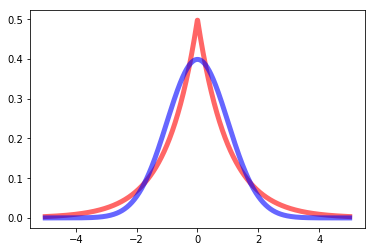

In [21]:
from scipy.stats import laplace, norm
fig, ax = plt.subplots()
x = np.linspace(-5,5,1000)
ax.plot(x, laplace.pdf(x),'r-', lw=5, alpha=0.6, label='laplace pdf')
ax.plot(x, norm.pdf(x),'b-', lw=5, alpha=0.6, label='gaussian pdf')

## L2 Regularization, Gaussian Prior

In [22]:
from functools import partial
lambs = torch.linspace(0.1,0.2,15)
loss = MSELoss()
regularizer = lambda w: torch.pow(torch.norm(w, p=2), 2)
L2_reg = LossWithRegularization(loss, regularizer, 0.003)
model_l2 = nn.Linear(w_size, 1, bias=False)
optimizer = Adam
best_idx, model_l2 = cross_validate(w_size, L2_reg, loader, optimizer, epochs,lambs, holdout,lr)
best_idx

14


8

# L1 Regularization, Double Exponential Prior

In [23]:
lambs = torch.linspace(0.01,0.2,20)
loss = MSELoss()
regularizer = partial(torch.norm, p=1)
L1_reg = LossWithRegularization(loss, regularizer, 0.01)
optimizer = Adam
best_idx, model_l1 = cross_validate(w_size, L1_reg, loader, optimizer, epochs,lambs, holdout,lr)
best_idx

19


11

## Measuring quality between the 3

In [26]:
t_size = 18000
test_X, test_y = build_data(center_pos, center_neg, 0.8, t_size)
loss = MSELoss()

In [27]:
for name, model in [("l1", model_l1), ("l2", model_l2), ("none", model_none)]:
    pred = model(test_X)
    mloss = loss(pred, test_y)
    print(f"{name}: {mloss}")

l1: 1.1456172466278076
l2: 1.1536186933517456
none: 1.3613648414611816


# Flipping things around

In [13]:
center_pos = torch.normal(mean=torch.zeros(w_size),std=1)
center_neg = center_pos + 0.5
center_pos = list(center_pos.squeeze())
center_neg = list(center_neg.squeeze())
X, train_labels = build_data(center_pos, center_neg, 0.1, 66)
holdout, holdout_labels = build_data(center_pos, center_neg, 0.1, 33)
holdout_obs = torch.cat((holdout, holdout_labels.unsqueeze(1)), dim=1) 
combined = torch.cat((X, train_labels.unsqueeze(1)), dim=1)
dataset = TensorDataset(combined)
model_none = nn.Linear(w_size, 1,bias=False)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = Adam(model_none.parameters(), lr=lr)
train(model_none, loss, loader, optimizer, epochs)
optimizer = Adam
best_idx, model_l2 = cross_validate(w_size, L2_reg, loader, optimizer, epochs,lambs, holdout,lr)
best_idx, model_l1 = cross_validate(w_size, L1_reg, loader, optimizer, epochs,lambs, holdout,lr)

8


KeyboardInterrupt: 

In [ ]:
t_size = 5000
test_X, test_y = build_data(center_pos, center_neg, 0.1, t_size)
loss = MSELoss()
for name, model in [("l1", model_l1), ("l2", model_l2), ("none", model_none)]:
    pred = model(test_X)
    mloss = loss(pred, test_y)
    print(f"{name}: {mloss}")